In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')


In [38]:
path = "InSDN_DatasetCSV/"

normal_df = pd.read_csv(f"{path}Normal_data.csv")
osv_df = pd.read_csv(f"{path}OVS.csv")
metasploit_df = pd.read_csv(f"{path}metasploitable-2.csv")



In [39]:
# Etiketlerdeki boşlukları ve büyük/küçük harf farklarını temizleyelim
df['Label'] = df['Label'].str.strip().str.lower()

# "ddos" etiketlerini birleştirip kontrol edelim
df['Label'] = df['Label'].replace('ddos', 'ddos')

# Etiketleri tekrar kontrol edelim
print(df['Label'].value_counts())

Label
ddos          121942
probe          98129
normal         68424
dos            53616
bfa             1405
web-attack       192
botnet           164
u2r               17
Name: count, dtype: int64


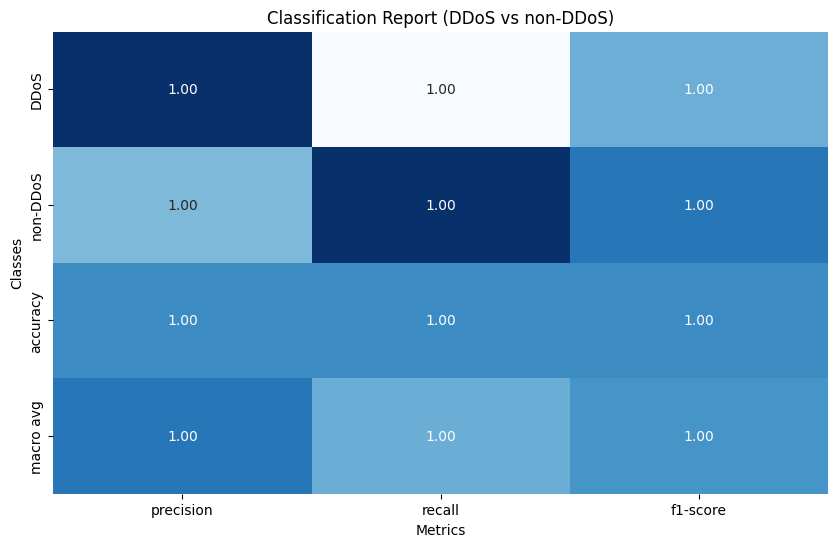

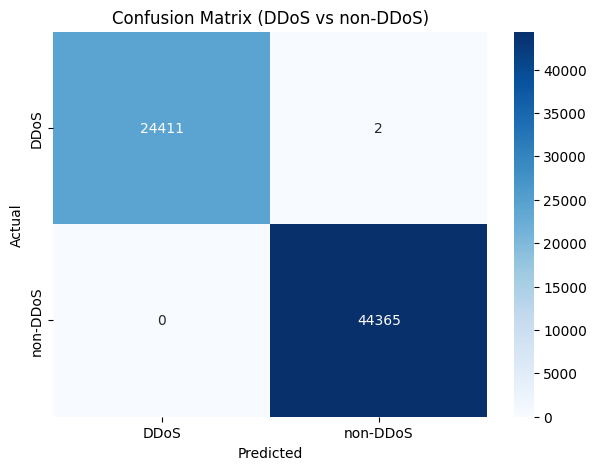

In [45]:
# Sayısal sütunları seçelim
# X = df.select_dtypes(include=['float64', 'int64'])

# # Sayısal veri tipi taşıyan sütunları kontrol edelim
# numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

# # Sayısal sütunları 1 tabanlı indeksle yazdıralım
# for idx, col in enumerate(numerical_columns, 1):
#     print(f"{idx}. {col}")


selected_columns = [
    'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 
    'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 
    'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 
    'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 
    'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 
    'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 
    'Bwd IAT Max', 'Bwd IAT Min', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 
    'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 
    'Pkt Len Var', 'Pkt Size Avg', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 
    'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min'
]

# Etiketleri küçük harfe çeviriyoruz (örneğin: 'DDoS', 'ddos' -> 'ddos')
df['Label'] = df['Label'].str.lower()

# Yeni etiketleme: sadece ddos -> 'DDoS', diğer her şey -> 'non-DDoS'
df['BinaryLabel'] = df['Label'].apply(lambda x: 'DDoS' if x == 'ddos' else 'non-DDoS')

# Yeni dataframe oluşturuyoruz
df_binary = df[selected_columns + ['BinaryLabel']]
X = df_binary[selected_columns]
y = df_binary['BinaryLabel']

# Eğitim ve test seti
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model eğitimi
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Tahmin ve sonuçlar
y_pred = rf_model.predict(X_test)

# Classification report
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Görselleştirme
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, fmt='.2f', cmap='Blues', cbar=False)
plt.title("Classification Report (DDoS vs non-DDoS)")
plt.xlabel("Metrics")
plt.ylabel("Classes")
plt.show()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['DDoS', 'non-DDoS'])

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['DDoS', 'non-DDoS'], yticklabels=['DDoS', 'non-DDoS'])
plt.title("Confusion Matrix (DDoS vs non-DDoS)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()




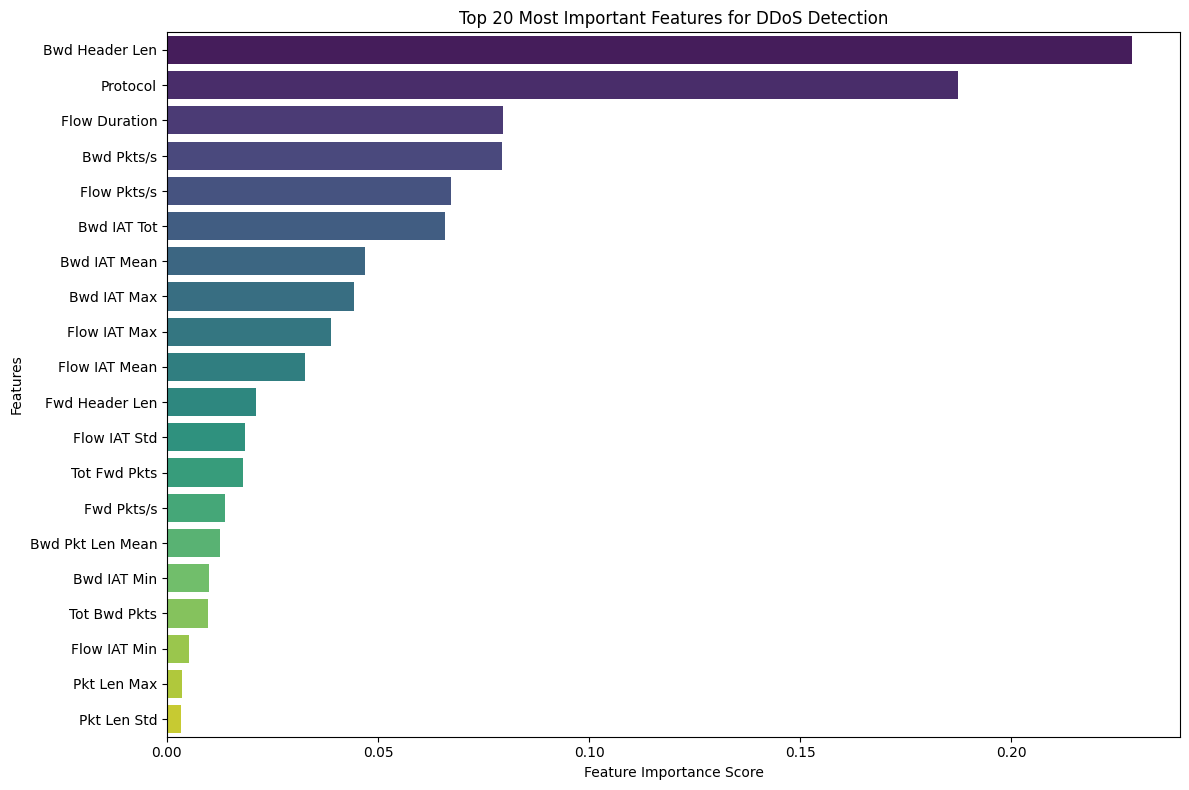

In [48]:
# Özelliklerin önem derecelerini alalım
importances = rf_model.feature_importances_

# Özellik isimleri ile birlikte DataFrame'e aktaralım
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Önem sırasına göre sıralayalım
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# En önemli ilk 20 özelliği görselleştirelim
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20), palette='viridis')
plt.title("Top 20 Most Important Features for DDoS Detection")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


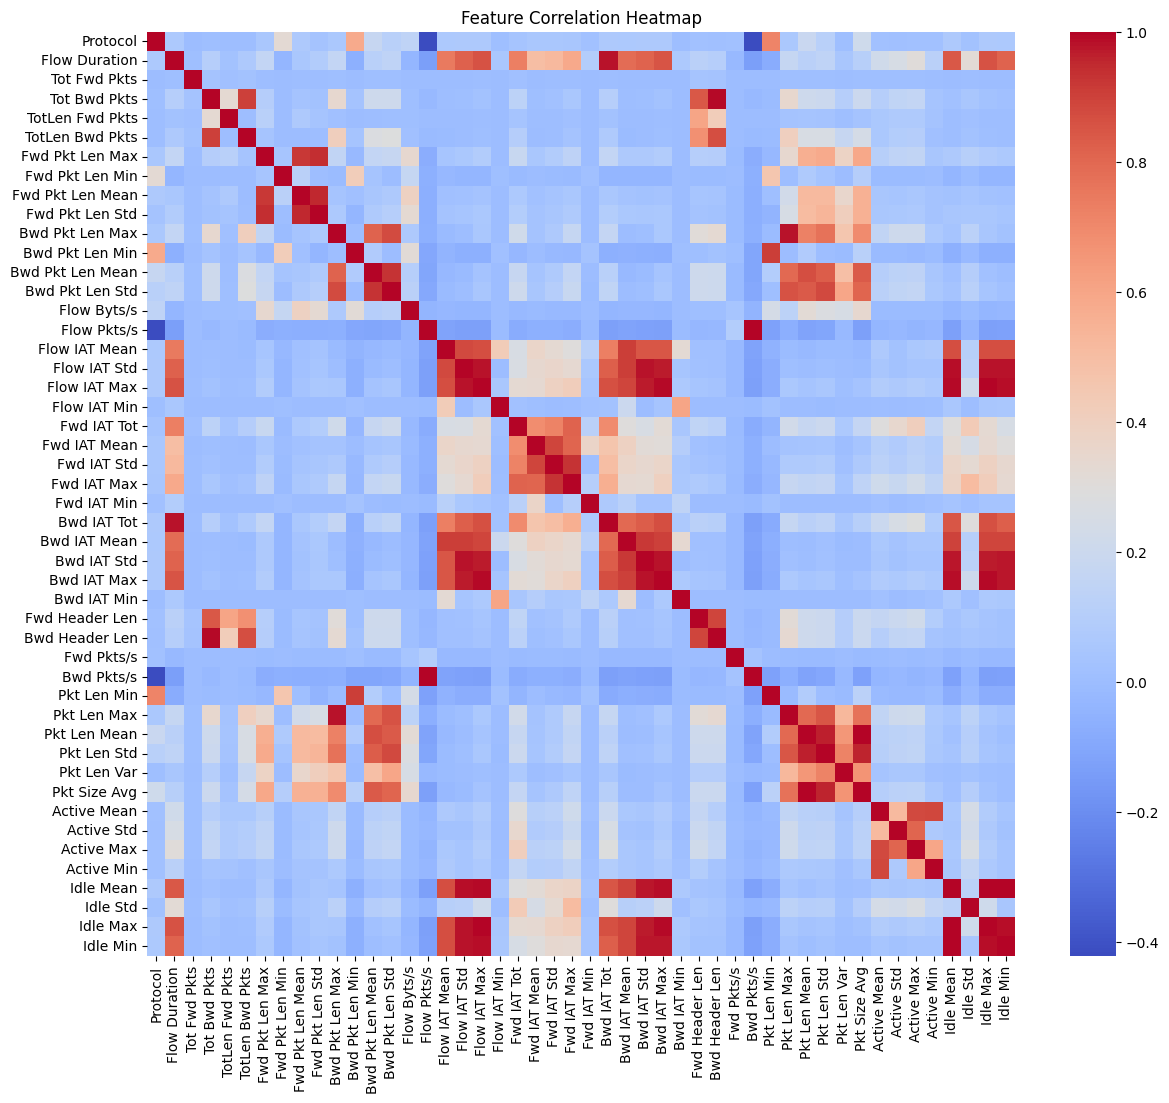

In [49]:
plt.figure(figsize=(14, 12))
sns.heatmap(df[selected_columns].corr(), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

In [69]:
import joblib
joblib.dump(rf_model, 'ddos_model.pkl')


['ddos_model.pkl']